In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve, train_test_split, GroupShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load
import periodictable as pt

from umda.data import load_data, load_pipeline
from umda import training
from umda import paths

plt.style.use("publication.mpl")

In [2]:
tmc1_df = load_data()[-1]

In [3]:
Y = np.log10(tmc1_df["Column density (cm^-2)"]).values

In [4]:
def count_atoms(mol, symbol: str) -> int:
    counter = 0
    return len([atom for atom in mol.GetAtoms() if atom.GetSymbol() == symbol])


def average_bond_order(mol) -> float:
    return np.mean([bond.GetBondTypeAsDouble() for bond in mol.GetBonds()])


def calc_mass(formula):
    weight = 0
    for atom, number in formula.atoms.items():
        weight += atom.mass * number
    return weight


def featurize_smiles(smi: str):
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    # makes sure that rdkit has stuff to work with
    mol.UpdatePropertyCache(strict=False)
    Chem.GetSymmSSSR(mol)
    atom_num = mol.GetNumAtoms()
    heavy_num = Descriptors.HeavyAtomCount(mol)
    bond_num = mol.GetNumBonds()
    mol_weight = Descriptors.MolWt(mol)
    num_rings = mol.GetRingInfo().NumRings()
    avg_bond_order = average_bond_order(mol)
    valence_electrons = Descriptors.NumValenceElectrons(mol)
    # atom counting features
    atom_counts = [count_atoms(mol, symbol) for symbol in ["C", "O", "N", "S", "P"]]
    features = [atom_num, bond_num, mol_weight, avg_bond_order, num_rings, valence_electrons]
    features.extend([descriptor(mol) for descriptor in [Descriptors.FpDensityMorgan1, Descriptors.FpDensityMorgan2, Descriptors.FpDensityMorgan3]])
    features.extend(atom_counts)
    return features

## Generate hand picked vectors

In [5]:
hand_vecs = np.asarray([featurize_smiles(smi) for smi in tmc1_df["SMILES"]])
# replace NaNs with 0
hand_vecs[np.isnan(hand_vecs)] = 0.

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Grab the mol2vec vectors

In [6]:
embedder = load_pipeline()

In [7]:
mol_vecs = np.asarray([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
# use the first 20 dimensions of PCA
# mol_vecs = mol_vecs[:,:30]

## Bootstrap the data

In [8]:
seed = 1290169267

In [9]:
((train_X, train_y), (test_X, test_y)), mol_indices = training.get_molecule_split_bootstrap(
    (mol_vecs, Y), seed=seed, n_samples=800, replace=True,
    noise_scale=0.5, molecule_split=0.2, test_size=0.2
    )

boot_mol_X = np.vstack([train_X, test_X])
boot_mol_Y = np.concatenate([train_y, test_y])

((train_X, train_y), (test_X, test_y)), hand_indices = training.get_molecule_split_bootstrap(
    (hand_vecs, Y), seed=seed, n_samples=800, replace=True,
    noise_scale=0.5, molecule_split=0.2, test_size=0.2
    )

boot_hand_X = np.vstack([train_X, test_X])
boot_hand_Y = np.concatenate([train_y, test_y])

cv = GroupShuffleSplit(20, test_size=0.2, random_state=seed)

In [10]:
# boot_mol_X, boot_mol_Y = get_bootstrap_samples((mol_vecs, Y), n_samples=400, seed=1215677)

In [11]:
# boot_hand_X, boot_hand_Y = get_bootstrap_samples((hand_vecs, Y), n_samples=400, seed=1215677)

In [12]:
# get the molecular weights
tmc1_df["weights"] = tmc1_df["Formula"].str.replace("+", "").str.replace("-", "").apply(lambda x: calc_mass(pt.formula(x)))

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


No handles with labels found to put in legend.


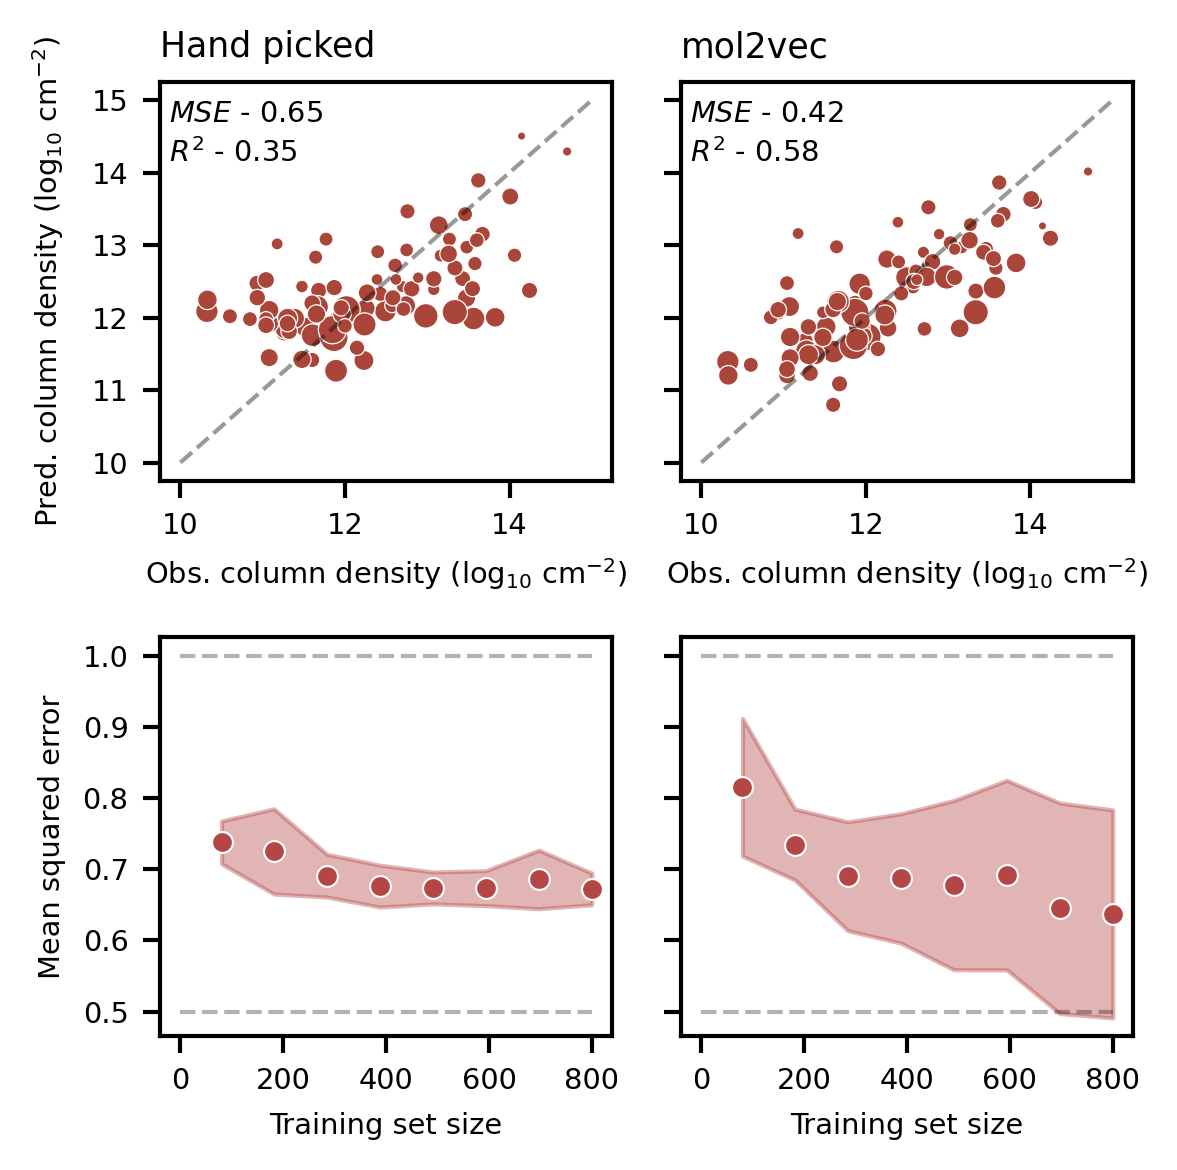

In [26]:
fig, axarray = plt.subplots(2, 2, figsize=(4, 4), sharey='row', sharex="row")

colors = ["#b44645", "#3a4e9d",]

train_sizes = np.linspace(0.1, 1., 8)

for label, axpair, data in zip(["Hand picked", "mol2vec"], axarray.T, [(boot_hand_X, boot_hand_Y, hand_vecs, hand_indices), (boot_mol_X, boot_mol_Y, mol_vecs, mol_indices)]):
    perf_ax, lc_ax = axpair
    model = Ridge(alpha=5., tol=1e-5)
    result = model.fit(data[0], data[1])
    pred_Y = result.predict(data[2])
    mse = mean_squared_error(Y, pred_Y)
    r2 = r2_score(Y, pred_Y)
    perf_ax.scatter(Y, pred_Y, s=0.3 * tmc1_df["weights"], lw=0.3, edgecolors="w")
    perf_ax.plot(np.arange(10, 16), np.arange(10, 16), ls="--", color="k", alpha=0.4)
    perf_ax.set_title(label, loc="left")
    perf_ax.text(0.02, 0.9, f"$MSE$ - {mse:.2f}", fontsize="x-small", transform=perf_ax.transAxes)
    perf_ax.text(0.02, 0.8, f"$R^2$ - {r2:.2f}", fontsize="x-small", transform=perf_ax.transAxes)
    # now do the learning curves
    steps, error = training.custom_learning_curve(
        model, (data[0], data[1], data[-1]), (data[2], Y), train_sizes, cv
        )
    mean_val, std_val = np.abs(error.mean(axis=1)), error.std(axis=1)
    # plot the learning curves up with CV uncertainty
    lc_ax.plot(steps, mean_val, "o", color=colors[0], mec="w", mew=0.5)
    lc_ax.fill_between(steps, mean_val+std_val, mean_val-std_val, alpha=0.4, color=colors[0])
    lc_ax.hlines([0.5, 1.], 0., steps.max(), ls="--", alpha=0.3)
    if label == "Hand picked":
        perf_ax.set(ylabel="Pred. column density ($\log_{10}$ cm$^{-2}$)")
        lc_ax.set(ylabel="Mean squared error")
        lc_ax.legend(fontsize="x-small", loc=1, ncol=2)
    perf_ax.set_xlabel("Obs. column density ($\log_{10}$ cm$^{-2}$)", fontsize="x-small")
    lc_ax.set_xlabel("Training set size")
fig.align_labels()
fig.savefig("outputs/ridge_handpicked_vs_mol2vec.pdf", dpi=150)

## "Tuning" $\alpha$

Since the argument could be made that $\alpha$ is not tuned well for the hand picked features, below we'll make a plot of a single train/test split, and fitting the same datasets to a ridge regressor with different values of $\alpha$. The idea here is that the hand picked features perform significantly worse regardless of regularization.

In [46]:
alpha_results = list()
alphas = 10**np.linspace(-1., 2., 10)

for label, data in zip(["Hand picked", "mol2vec"], [(boot_hand_X, boot_hand_Y, hand_vecs, hand_indices), (boot_mol_X, boot_mol_Y, mol_vecs, mol_indices)]):
    x, y, vecs, indices = data
    for alpha in alphas:
        model = Ridge(alpha, tol=1e-5)
        errors = list()
        for split in cv.split(x, y, indices):
            train, test = split
            result = model.fit(x[train], y[train])
            errors.append(mean_squared_error(Y, result.predict(vecs)))
        mean_error, std_error = np.mean(errors), np.std(errors)
        alpha_results.append({"features": label, "alpha": np.log10(alpha), "mean": mean_error, "std": std_error})

In [47]:
df = pd.DataFrame(alpha_results)

from matplotlib.lines import Line2D

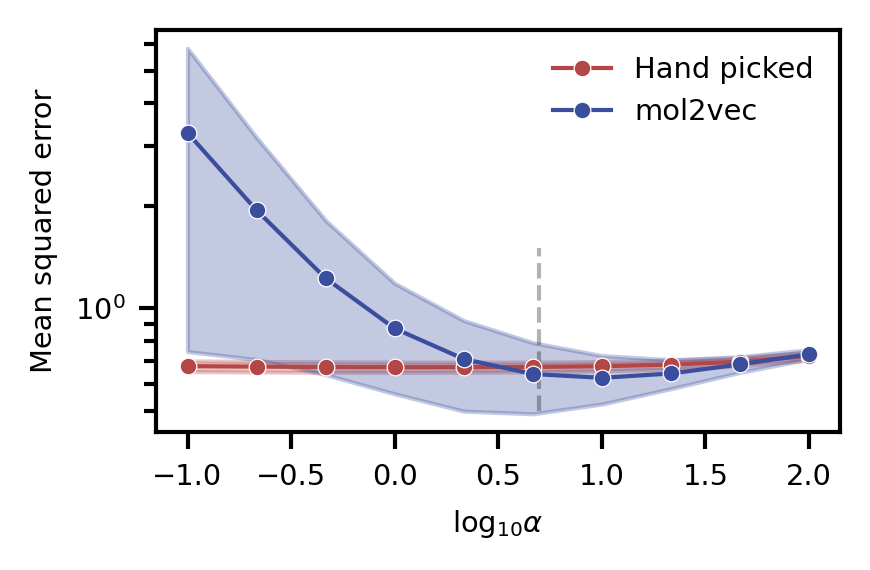

In [54]:
fig, ax = plt.subplots(figsize=(3, 2))

colors = ["#b44645", "#3a4e9d",]

for key, color in zip(df["features"].unique(), colors):
    temp = df.loc[df["features"] == key]
    ax.plot(temp["alpha"], temp["mean"], marker="o", markersize=4., mec="w", mew=0.3, color=color)
    ax.fill_between(temp["alpha"], temp["mean"] + temp["std"], temp["mean"] - temp["std"], color=color, alpha=0.3)
    # for col, marker in zip(["train_error", "test_error"], ["o", "s"]):
    #     ax.plot(temp["alpha"], temp[col], marker=marker, markersize=4., mec="w", mew=0.3, color=color)
ax.set(xlabel="$\\log_{10} \\alpha$", ylabel="Mean squared error")
# ax.text(0.2, 0.8, "Hand picked", transform=ax.transAxes, color="#b44645", fontsize="x-small", verticalalignment="center")
# ax.text(0.2, 0.2, "mol2vec", transform=ax.transAxes, color="#3a4e9d", fontsize="x-small", verticalalignment="center")
ax.vlines(np.log10(5.), 5e-1, 1.5, ls="--", alpha=0.3)
ax.set(yscale="log")
legend_elements = [
    Line2D([0], [0], marker="o", label="Hand picked", markersize=4., mec="w", mew=0.3, color="#b44645"),
    Line2D([0], [0], marker="o", label="mol2vec", markersize=4., mec="w", mew=0.3, color="#3a4e9d")
]
ax.legend(handles=legend_elements, fontsize="x-small")
fig.savefig("outputs/handpicked_alpha_hparam.pdf", dpi=150)

## Number of PCA dimensions

In [69]:
dimensions = np.arange(5, 71, 5).astype(int)

baseline = Ridge(5., tol=1e-5)
baseline_errors = list()
for split in cv.split(boot_hand_X, boot_hand_Y, hand_indices):
    train, test = split
    baseline.fit(boot_hand_X[train], boot_hand_Y[train])
    baseline_errors.append(mean_squared_error(Y, baseline.predict(hand_vecs)))
bline_mean, bline_std = np.mean(baseline_errors), np.std(baseline_errors)

dim_errors = list()

for dim in dimensions:
    model = Ridge(5., tol=1e-5)
    errors = list()
    for split in cv.split(boot_mol_X, boot_mol_Y, mol_indices):
        train, test = split
        result = model.fit(x[train][:,:dim], y[train])
        errors.append(mean_squared_error(Y, result.predict(vecs[:,:dim])))
    mean_error, std_error = np.mean(errors), np.std(errors)
    dim_errors.append({"dimensions": dim, "mean": mean_error, "std": std_error})

In [70]:
df = pd.DataFrame(dim_errors)

No handles with labels found to put in legend.


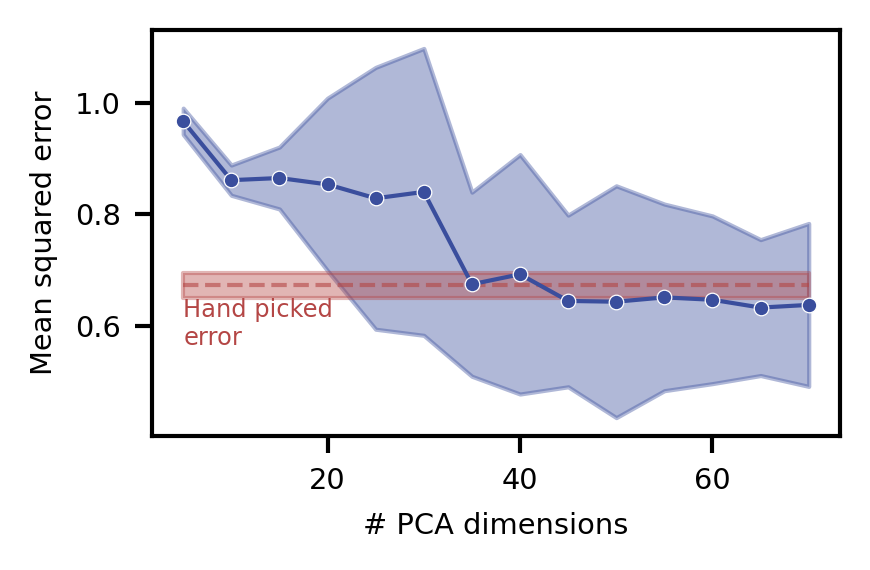

In [78]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(df["dimensions"], df["mean"], marker="o", markersize=3.5, mec="w", mew=0.3, color="#3a4e9d")
ax.fill_between(df["dimensions"], df["mean"] + df["std"], df["mean"] - df["std"], color="#3a4e9d", alpha=0.4)

ax.hlines(bline_mean, 5., 70., ls=["--"], color="#b44645", alpha=0.6)
ax.fill_between(df["dimensions"], bline_mean + bline_std, bline_mean - bline_std, color="#b44645", alpha=0.4)
ax.text(5, bline_mean - bline_std, "Hand picked\nerror", fontsize="xx-small", verticalalignment="top", color="#b44645")
# ax.text(5, baseline_test - 0.01, "Baseline\ntest error", fontsize="xx-small", verticalalignment="top", color="#b44645")
ax.legend(fontsize="x-small", ncol=2)
ax.set(xlabel="# PCA dimensions", ylabel="Mean squared error")
fig.savefig("outputs/handpicked_pca_dimensions.pdf", dpi=150)